Implementation of the base model (June 12)
---

In [7]:
from gurobipy import Model, GRB, quicksum

## 0 Instances

In [8]:
# Example inputs
# HelloWorld
# Hello there
n = 4  # Number of flights
m = 2  # Number of real gates

T = [
    [0, 10, 15, 20],  # Flight 1 can sequentially follow Flights 2, 3, 4
    [10, 0, 15, 25],  # Flight 2 can sequentially follow Flights 1, 3, 4
    [15, 15, 0, 30],  # Flight 3 can sequentially follow Flights 1, 2, 4
    [20, 25, 30, 0]   # Flight 4 can sequentially follow Flights 1, 2, 3
]
P = [
    [50, 30],  # Preferences of Flight 1 for Gates 1 and 2
    [40, 60],  # Preferences of Flight 2 for Gates 1 and 2
    [30, 70],  # Preferences of Flight 3 for Gates 1 and 2
    [20, 80]   # Preferences of Flight 4 for Gates 1 and 2
]
U = [0, 1, 2, 3]
M = [
    [0, 1],  # Flight 1 can go to Gates 1 and 2
    [0, 1],  # Flight 2 can go to Gates 1 and 2
    [0, 1],  # Flight 3 can go to Gates 1 and 2
    [0, 1]   # Flight 4 can go to Gates 1 and 2
]

alpha1 = 1   # Preference scaling factor
alpha2 = 50  # Reward for avoiding tows
alpha3 = 5   # Penalty scaling factor for buffer time deficits

t_max = 30

# Shadow Restrictions
shadow_restrictions = [
    (0, 0, 1, 1), # Activity 1 at Gate 0 and Activity 2 at Gate 1 cannot happen
    (2, 2, 3, 1)  # Activity 3 at Gate 2 and Activity 4 at Gate 1 cannot happen
]

1 Flight-Gate Scheduling (FGS) Problem
---

In [9]:
def build_FGS_model(n, m, P, U, T, M, shadow_restrictions, alpha1, alpha2, alpha3, t_max):
    model = Model("FlightGateScheduling")

    # Decision variables for each activity being assigned to each gate
    x = model.addVars(n, m + 1, vtype=GRB.BINARY, name="x") # Number of real gates is num_gates; the last index is assumed to be the dummy gate

    # Constraints
    # Assign each activity to exactly one of its allowable gates
    for i in range(n):
        model.addConstr(quicksum(x[i, j] for j in range(m) if j in M[i]) == 1, name=f"Assign_{i}")

    # Non-overlapping constraint (1)
    for i in range(n):
        for j in range(n):
            if T[i][j] < 0:
                for k in range(m):
                    model.addConstr(x[i, k] + x[j, k] <= 1, name=f"Overlap_{i}_{j}_{k}")

    # Shadow restrictions (2)
    for (i, k, j, l) in shadow_restrictions:
        model.addConstr(x[i, k] + x[j, l] <= 1, name=f"Shadow_{i}_{j}")

    # Objective components (3)
    
    # Append significantly negative scores for the dummy gate
    P_star = [prefs + [-1000] for prefs in P]  # Add a very undesirable score for the dummy gate

    # z1: Minimize the negative sum of adjusted preferences
    z1 = quicksum(P_star[i][j] * x[i, j] for i in range(n) for j in range(m + 1))
    
   
    # Define a new decision variable for tows between activities and their successors
    tows = model.addVars(n, m, vtype=GRB.BINARY, name="tows")

    # Update constraints to calculate tows:
    for i in range(n):
        if U[i] != 0:  # Has a valid successor
            for k in range(m):
                # If activity i is assigned to gate k and its successor U[i] to a different gate
                model.addConstr(tows[i, k] >= x[i, k] - x[U[i], k], name=f"TowIfDifferent1_{i}_{k}")
                model.addConstr(tows[i, k] >= x[U[i], k] - x[i, k], name=f"TowIfDifferent2_{i}_{k}")

    # Redefine z2 using the new tow variables
    z2 = quicksum(tows[i, k] for i in range(n) for k in range(m))

    # z3: Buffer time deficit
    z3 = quicksum(max(t_max - T[i][j], 0) * x[i, k] * x[j, k] 
                  for i in range(n) for j in range(i +1, n) for k in range(m))

    # Combined objective
    model.setObjective(alpha1 * z1 + alpha2 * z2 + alpha3 * z3, GRB.MINIMIZE)
    model.optimize()

    return model, x

In [10]:
# Build the model
model, x = build_FGS_model(n, m, P, U, T, M, shadow_restrictions, alpha1, alpha2, alpha3, t_max)  # Receive model and decision variables

# Print the results
if model.status == GRB.OPTIMAL:
    assignments = model.getAttr('X', x)
    for i in range(n):
        for j in range(m):
            if assignments[i, j] > 0.5:
                print(f"Activity {i} assigned to Gate {j}")


Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (mac64[arm] - Darwin 23.4.0 23E224)

CPU model: Apple M1
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 18 rows, 20 columns and 24 nonzeros
Model fingerprint: 0x61b63570
Model has 10 quadratic objective terms
Variable types: 0 continuous, 20 integer (20 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [2e+01, 1e+03]
  QObjective range [5e+01, 2e+02]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+00]
Found heuristic solution: objective -2380.000000
Presolve removed 17 rows and 17 columns
Presolve time: 0.00s
Presolved: 4 rows, 6 columns, 11 nonzeros
Found heuristic solution: objective -3780.000000
Variable types: 0 continuous, 6 integer (6 binary)

Explored 0 nodes (0 simplex iterations) in 0.01 seconds (0.00 work units)
Thread count was 8 (of 8 available processors)

Solution count 2: -3780 -2380 
No other solutions better than -3780


2 FGS as Clique Partitioning Problem (CPP)
---

Assumptions
1. Flights are represented as nodes in a graph.
2. Conflicts between flights are represented as edges.
3. Each clique represents a set of flights that can be assigned to the same gate without conflict.

In [11]:
def build_cpp_model(n, m, T, P, U, M, alpha1, alpha2, alpha3, t_max):
    model = Model("GateAssignmentCPP")

    # Total vertices: flights + gates (5)
    a = n + m - 1
    
    # Initialize the edge weights matrix
    weights = [[0] * a for _ in range(a)]
    
    # Populate the weights matrix based on given rules (6)
    for i in range(n):
        for j in range(n):
            if i != j:
                if T[i][j] < 0:
                    weights[i][j] = float('-inf')  # Activities overlap in time
                elif U[i] == j or U[j] == i:
                    weights[i][j] = alpha2  # Saving a tow
                else:
                    weights[i][j] = -alpha3 * max(t_max - T[i][j], 0)  # Buffer time difference
                
    # Weights for flight to gate assignments (7)
    for i in range(n):
        for j in range(n, a):
            if j - n in M[i]:
                weights[i][j] = alpha1 * P[i][j - n]
            else:
                weights[i][j] = float('-inf')
    
    # Gates cannot be in the same clique (8)
    for i in range(n, a):
        for j in range(n, a):
            weights[i][j] = float('-inf')
    
    # Decision variables: x[i, j] = 1 if i and j are in the same clique
    x = model.addVars(a, a, vtype=GRB.BINARY, name="x")
    
    # Objective: Maximize the sum of the weights for edges within the same clique
    model.setObjective(quicksum(weights[i][j] * x[i, j] for i in range(a) for j in range(i + 1, a)), GRB.MAXIMIZE)

    # Add transitivity constraints for forming valid cliques (4)
    for i in range(a):
        for j in range(a):
            for k in range(a):
                if 1 <= i and i < j and j < k and k <= a:
                    model.addConstr(x[i, j] + x[j, k] - x[i, k] <= 1)
                    model.addConstr(x[i, j] - x[j, k] + x[i, k] <= 1)
                    model.addConstr(-x[i, j] + x[j, k] + x[i, k] <= 1)

    # Symmetric constraints: x[i, j] should be equal to x[j, i]
    for i in range(a):
        for j in range(i + 1, a):
            model.addConstr(x[i, j] == x[j, i])


    model.optimize()
    return model

# Example usage (parameters need to be defined: n, m, T, P, alpha1, alpha2, alpha3, t_max, U, M)
# n = number of flights, m = number of gates
# T = matrix of time differences, P = preferences matrix
# alpha1, alpha2, alpha3 = weight factors, t_max = maximum buffer time
# U = successor function, M = valid gate assignments for each flight


In [12]:
# Build the model
model = build_cpp_model(n, m, T, P, U, M, alpha1, alpha2, alpha3, t_max)

# Print the results
if model.status == GRB.OPTIMAL:
    print("Optimal assignment found with total score:", model.objVal)

Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (mac64[arm] - Darwin 23.4.0 23E224)

CPU model: Apple M1
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 22 rows, 25 columns and 56 nonzeros
Model fingerprint: 0x3d1922cc
Variable types: 0 continuous, 25 integer (25 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [2e+01, 1e+02]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+00]
Found heuristic solution: objective -0.0000000
Presolve removed 10 rows and 19 columns
Presolve time: 0.00s
Presolved: 12 rows, 6 columns, 36 nonzeros
Found heuristic solution: objective 90.0000000
Variable types: 0 continuous, 6 integer (6 binary)

Root relaxation: objective 1.000000e+02, 2 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

*    0     0               0

## Draw a graph

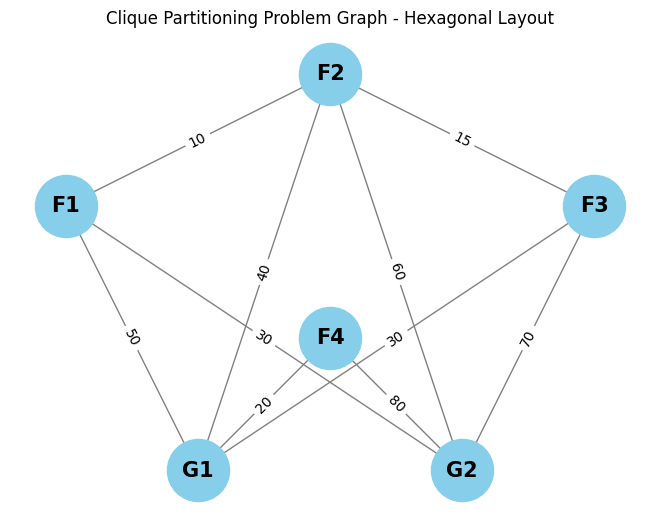

In [13]:
import networkx as nx
import matplotlib.pyplot as plt

def draw_cpp_graph(flights, gates, connections):
    """
    Draws a CPP graph with given flight and gate nodes and their connections in a hexagonal-like layout.
    
    Parameters:
    - flights (dict): Dictionary where keys are flight labels and values are dicts of gate connections with weights.
    - gates (list): List of gate labels.
    - connections (dict): Optional additional edges between flights with weights.
    """
    # Create a graph
    G = nx.Graph()

    # Add nodes for flights and gates
    G.add_nodes_from(flights.keys(), style='filled', fillcolor='red', shape='circle')
    G.add_nodes_from(gates, style='filled', fillcolor='blue', shape='square')

    # Add edges between flights and gates with preferences
    for flight, prefs in flights.items():
        for gate, weight in prefs.items():
            G.add_edge(flight, gate, weight=weight)

    # Add optional additional connections between flights
    for (f1, f2), weight in connections.items():
        G.add_edge(f1, f2, weight=weight)

    # Manually define positions for a hexagonal-like layout
    pos = {
        'F1': (-1, 1), 'F2': (0, 2), 'F3': (1, 1),  # Top vertex, and middle row vertices
        'F4': (0, 0),  # Bottom vertex of the upper hexagon (if we imagine a hexagon)
        'G1': (-0.5, -1), 'G2': (0.5, -1)  # Bottom vertices (gates)
    }

    # Draw the network
    nx.draw(G, pos, with_labels=True, node_color='skyblue', edge_color='gray', node_size=2000, font_size=15, font_weight='bold')

    # Draw edge labels
    edge_labels = nx.get_edge_attributes(G, 'weight')
    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels)

    plt.title("Clique Partitioning Problem Graph - Hexagonal Layout")
    plt.axis('off')  # Hide the axes
    plt.show()

# Example usage
flights = {
    'F1': {'G1': 50, 'G2': 30},
    'F2': {'G1': 40, 'G2': 60},
    'F3': {'G1': 30, 'G2': 70},
    'F4': {'G1': 20, 'G2': 80}
}
gates = ['G1', 'G2']
additional_connections = {('F1', 'F2'): 10, ('F2', 'F3'): 15}

draw_cpp_graph(flights, gates, additional_connections)
